In [143]:
!pip install datasets
!pip install transformers
!pip install accelerate
!pip install sentencepiece

!python -m spacy download pt_core_news_sm

2023-12-02 14:10:28.797776: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-02 14:10:28.797827: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-02 14:10:28.797861: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-02 14:10:29.987241: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 36.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [144]:
from datasets import load_dataset

In [145]:
dataset = load_dataset('joelniklaus/brazilian_court_decisions')

In [146]:
dataset

DatasetDict({
    train: Dataset({
        features: ['process_number', 'orgao_julgador', 'publish_date', 'judge_relator', 'ementa_text', 'decision_description', 'judgment_text', 'judgment_label', 'unanimity_text', 'unanimity_label'],
        num_rows: 3234
    })
    validation: Dataset({
        features: ['process_number', 'orgao_julgador', 'publish_date', 'judge_relator', 'ementa_text', 'decision_description', 'judgment_text', 'judgment_label', 'unanimity_text', 'unanimity_label'],
        num_rows: 404
    })
    test: Dataset({
        features: ['process_number', 'orgao_julgador', 'publish_date', 'judge_relator', 'ementa_text', 'decision_description', 'judgment_text', 'judgment_label', 'unanimity_text', 'unanimity_label'],
        num_rows: 405
    })
})

In [147]:
train_texts = dataset['train']['decision_description']
train_labels = dataset['train']['judgment_label']

validation_texts = dataset['validation']['decision_description']
validation_labels = dataset['validation']['judgment_label']

test_texts = dataset['test']['decision_description']
test_labels = dataset['test']['judgment_label']

print(f'\nTrain size: {len(train_texts)} -- {len(train_labels)}')
print(f'Validation size: {len(validation_texts)} -- {len(validation_labels)}')
print(f'Test size: {len(test_texts)} -- {len(test_labels)}')


Train size: 3234 -- 3234
Validation size: 404 -- 404
Test size: 405 -- 405


In [148]:
from collections import Counter

print(f'Train Labels Distribution: {Counter(train_labels)}')
print(f'Validation Labels Distribution: {Counter(validation_labels)}')
print(f'Test Labels Distribution: {Counter(test_labels)}')

Train Labels Distribution: Counter({'no': 1960, 'partial': 677, 'yes': 597})
Validation Labels Distribution: Counter({'no': 221, 'partial': 96, 'yes': 87})
Test Labels Distribution: Counter({'no': 234, 'partial': 93, 'yes': 78})


In [149]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

label_encoder.fit(train_labels)

train_labels = label_encoder.transform(train_labels)
validation_labels = label_encoder.transform(validation_labels)
test_labels = label_encoder.transform(test_labels)

print(f'Train Labels Distribution: {Counter(train_labels)}')
print(f'Validation Labels Distribution: {Counter(validation_labels)}')
print(f'Test Labels Distribution: {Counter(test_labels)}')

Train Labels Distribution: Counter({0: 1960, 1: 677, 2: 597})
Validation Labels Distribution: Counter({0: 221, 1: 96, 2: 87})
Test Labels Distribution: Counter({0: 234, 1: 93, 2: 78})


In [150]:
import spacy

from tqdm import tqdm

def preprocess_texts(list_texts):
  nlp = spacy.load('pt_core_news_sm', disable=['ner'])
  new_texts = []
  with tqdm(total=len(list_texts), desc='Preprocessing') as pbar:
    for text in list_texts:
      doc = nlp(text)
      tokens = [t.lemma_.lower() for t in doc if t.pos_ != 'PUNCT'
                and not t.is_stop]
      texto_normalizado = ' '.join(tokens)
      new_texts.append(texto_normalizado)
      pbar.update(1)
  return new_texts

In [151]:
train_texts = preprocess_texts(train_texts)

Preprocessing: 100%|██████████| 3234/3234 [01:15<00:00, 42.82it/s]


In [152]:
validation_texts = preprocess_texts(validation_texts)

Preprocessing: 100%|██████████| 404/404 [00:06<00:00, 58.93it/s]


In [153]:
test_texts = preprocess_texts(test_texts)

Preprocessing: 100%|██████████| 405/405 [00:06<00:00, 65.61it/s]


In [154]:
num_epochs = 5
batch_size = 8
max_len = 512
num_classes = 3

optim = 'adamw_torch'

# model_architecture = 'bertimbau_base'
model_architecture = 'legal_bertimbau_base'
# model_architecture = 'legal_bert_pt'

if model_architecture == 'bertimbau_base':
  model_path = 'neuralmind/bert-base-portuguese-cased'
elif model_architecture == 'legal_bertimbau_base':
  model_path = 'rufimelo/Legal-BERTimbau-base'
elif model_architecture == 'legal_bert_pt':
  model_path = 'raquelsilveira/legalbertpt_sc'

print(f'\nModel Architecture: {model_architecture}')


Model Architecture: legal_bertimbau_base


In [155]:
from transformers import BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=num_classes)

print(f'Parameters: {model.num_parameters():,}')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at rufimelo/Legal-BERTimbau-base and are newly initialized: ['bert.pooler.dense.bias', 'classifier.bias', 'classifier.weight', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Parameters: 108,925,443


In [156]:
import torch
import torch.nn.functional as f

y_train = torch.tensor(train_labels)
y_val = torch.tensor(validation_labels)
y_test = torch.tensor(test_labels)

y_train = f.one_hot(y_train, num_classes=num_classes)
y_val = f.one_hot(y_val, num_classes=num_classes)
y_test = f.one_hot(y_test, num_classes=num_classes)

y_train

tensor([[0, 1, 0],
        [1, 0, 0],
        [1, 0, 0],
        ...,
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]])

In [157]:
train_dict = {
    'text': train_texts,
    'label': y_train
}

val_dict = {
    'text': validation_texts,
    'label': y_val
}

test_dict = {
    'text': test_texts,
    'label': y_test
}

In [158]:
from datasets import Dataset

train_dataset = Dataset.from_dict(train_dict)
val_dataset = Dataset.from_dict(val_dict)
test_dataset = Dataset.from_dict(test_dict)

In [159]:
def tokenize_text(examples, tokenizer, max_len):
  return tokenizer(examples['text'], padding='max_length', max_length=max_len,
                   truncation=True)

In [160]:
encoded_train_dataset = train_dataset.map(lambda x: tokenize_text(x, tokenizer, max_len), batched=True, batch_size=batch_size)

encoded_val_dataset = val_dataset.map(lambda x: tokenize_text(x, tokenizer, max_len), batched=True, batch_size=batch_size)

encoded_test_dataset = test_dataset.map(lambda x: tokenize_text(x, tokenizer, max_len), batched=True, batch_size=batch_size)

Map:   0%|          | 0/3234 [00:00<?, ? examples/s]

Map:   0%|          | 0/404 [00:00<?, ? examples/s]

Map:   0%|          | 0/405 [00:00<?, ? examples/s]

In [161]:
import numpy as np

from sklearn.metrics import accuracy_score


def compute_classification_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  labels = np.argmax(labels, axis=-1)
  acc = accuracy_score(labels, predictions)
  return {
      'acc': acc
  }

In [162]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

training_args = TrainingArguments(output_dir='training/', logging_strategy='epoch',
                                  optim=optim, logging_steps=10, eval_steps=10,
                                  learning_rate=5e-5, weight_decay=0.01,
                                  evaluation_strategy='epoch',
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  num_train_epochs=num_epochs, save_strategy='epoch',
                                  load_best_model_at_end=True, metric_for_best_model='acc',
                                  greater_is_better=True, report_to=['none'])

trainer = Trainer(model=model, args=training_args,
                  train_dataset=encoded_train_dataset,
                  eval_dataset=encoded_val_dataset,
                  compute_metrics=compute_classification_metrics,
                  callbacks=[EarlyStoppingCallback(early_stopping_patience=2)])

trainer.train()

Epoch,Training Loss,Validation Loss,Acc
1,0.537100,0.497702,0.631188
2,0.432800,0.479847,0.698020
3,0.338300,0.495216,0.720297
4,0.255500,0.534956,0.735149
5,0.192200,0.587480,0.730198


TrainOutput(global_step=2025, training_loss=0.35117729657962, metrics={'train_runtime': 1637.1198, 'train_samples_per_second': 9.877, 'train_steps_per_second': 1.237, 'total_flos': 4254543964661760.0, 'train_loss': 0.35117729657962, 'epoch': 5.0})

In [163]:
y_pred, _, _ = trainer.predict(encoded_test_dataset)

In [164]:
predicted_labels = np.argmax(y_pred, axis=-1)

predicted_labels

array([2, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 2, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1,
       1, 2, 0, 0, 0, 1, 2, 0, 0, 0, 0, 2, 1, 2, 2, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 2, 2, 1, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 1, 1,
       1, 1, 1, 0, 2, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 2, 2, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 2, 1, 2, 2, 2, 0, 2, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       2, 1, 1, 2, 0, 0, 0, 0, 0, 1, 2, 0, 1, 1, 0, 2, 1, 0, 0, 0, 1, 2,
       0, 0, 0, 1, 1, 2, 1, 1, 0, 2, 1, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2, 0,
       2, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 2, 0, 2, 0, 0, 0, 0, 2, 0, 1, 0, 0, 1, 1,
       2, 0, 1, 2, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,

In [165]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import pandas as pd

report = classification_report(test_labels, predicted_labels)

print(report)

report = classification_report(test_labels, predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()

results = {}
results.update({model_architecture :
                      { 'Acurácia': df.loc['accuracy'][0],
                        'Precisão': df.loc['weighted avg']['precision'],
                        'Cobertura': df.loc['weighted avg']['recall'],
                        'F1-Score': df.loc['weighted avg']['f1-score']}
                  })

print(f'Model Architecture: {model_architecture}')
print(f'Num epochs: {num_epochs}')

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       234
           1       0.66      0.73      0.69        93
           2       0.68      0.54      0.60        78

    accuracy                           0.78       405
   macro avg       0.73      0.72      0.72       405
weighted avg       0.78      0.78      0.77       405

Model Architecture: legal_bertimbau_base
Num epochs: 5


,Acurácia,Precisão,Cobertura,F1-Score
legal_bertimbau_base,0.777778,0.775585,0.777778,0.774656


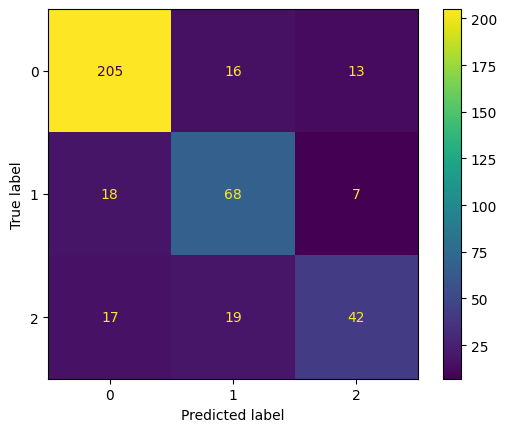

In [166]:
ConfusionMatrixDisplay.from_predictions(test_labels, predicted_labels)